#Clasificador de Tweets: Positivos o Negativos
                                            Danae Sánchez Villegas 136040
                                            Aprendizaje de Máquina

#Librerías

In [1]:
import pandas as pd
from sklearn import linear_model, decomposition
import csv
from sklearn.cross_validation import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix,  roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
%matplotlib inline

#Preprocesamiento

# Tokenizar el texto de un tweet 

In [2]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)

def tokenTweet(tweet):
    
    # process the tweets
   
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
   
    return tokens_re.findall(tweet)


In [3]:
# Test the classifier
testTweet = 'Felicidades!, @ravikiranj #feliz https://wikipedia.com :).'
processedTestTweet = tokenTweet(testTweet)
processedTestTweet
#print NBClassifier.classify(extract_features(getFeatureVector(processedTestTweet)))

['felicidades', '!', ',', 'AT_USER', 'feliz', 'URL', ':)', '.']

# Remover "stop-words" y letras repetidas

In [4]:
def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

def stopWords (tokens):
    #spanish_stemmer=SnowballStemmer("spanish")
    punctuation = list(string.punctuation)
    stop = stopwords.words('spanish') + punctuation + ['rt', 'via','?','!',',','AT_USER','URL','','xc3','\xba','\xa1','\xc3','\xad','\xa9','\xc2','\xbf','x80','x9c','xa1','xb1','xdd','xbf','xc2','xa9','xba']
    terms_stop= list() 

    for terms in range(len(tokens)): 
        
        tokens[terms] = replaceTwoOrMore(tokens[terms])
    
            #strip punctuation
        #tokens[terms] = tokens[terms].strip('\'"?,.')
        if tokens[terms] not in stop:
            #tokens[terms]=spanish_stemmer.stem(tokens[terms])
            terms_stop.append(tokens[terms])
            

        
    return terms_stop
l=stopWords(processedTestTweet)
l

['felicidades', 'feliz', ':)']

#1. Función para preprocesar tweets

In [5]:
l=list()
l.append(testTweet)
def preprocessTweets(tweets):
    featureVector=list()
    for x in range(len(tweets)):
        featureVector.append(stopWords(tokenTweet(tweets[x])))
    return featureVector
preprocessTweets(l)

[['felicidades', 'feliz', ':)']]

#2. Cargar, preprocesar, y dividir datos

In [6]:
df=pd.read_csv("proyecto.csv")
texto= df['text']
sent=df['sentiment']
tokens=preprocessTweets(texto)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



#Dividir datos en entrenamiento y prueba

In [7]:
# Dividir los conjuntos training/testing 
x_train, x_test, y_train, y_test = train_test_split(
   tokens,sent,train_size=0.75)
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)

#Tweets Variable

In [8]:
tweetsVar=zip(x_train,y_train)
tweetsVarT=zip(x_test,y_test)

#3. Atributos

In [9]:
def listOfeatures(tokens):
    featureList= list() 
    for i in range(len(tokens)):

            for terms in range(len(tokens[i])): 
                featureList.append(tokens[i][terms])
    #quitar repetidos
    return (set(featureList))
featureList=listOfeatures(x_train)

#Map string features to numeric values 

In [10]:
def getNumFeatureVectorAndLabels(tweets, featureList):
    
    sortedFeatures = sorted(featureList)
    map = {}
    feature_vector = []
    labels = []
    for t in tweets:
        label = 0
        map = {}
        #Initialize empty map
        for w in sortedFeatures:
            map[w] = 0

        tweet_words = t[0]
        tweet_opinion = t[1]
        #Fill the map
        for word in tweet_words:
            #process the word (remove repetitions and punctuations)
            #word = replaceTwoOrMore(word)
            word = word.strip('\'"?,.')
            #set map[word] to 1 if word exists
            if word in map:
                map[word] = 1
                
        #end for loop
        values = map.values()
        feature_vector.append(values)
        if(tweet_opinion == 'Positive'):
            label = 0
            
        elif(tweet_opinion == 'Negative'):
            label = 1
            
        #elif(tweet_opinion == 'Neutral'):
         #   label = 2
            
        labels.append(label)
    #return the list of feature_vector and labels
    return (feature_vector, labels)


#Numeric X and T

In [105]:
[x_train, y_train]=getNumFeatureVectorAndLabels(tweetsVar,featureList)
[x_test, y_test]=getNumFeatureVectorAndLabels(tweetsVarT,featureList)

#Normalizar x


In [108]:
x_train = preprocessing.normalize(np.asarray(x_train).astype(float), norm='l2')
x_test = preprocessing.normalize(np.asarray(x_test).astype(float), norm='l2')
np.matrix.mean(np.asmatrix(x_train))

0.00031585504643131342

#PCA

In [ ]:
pca = decomposition.PCA(n_components=8)
pca.fit(x_train)

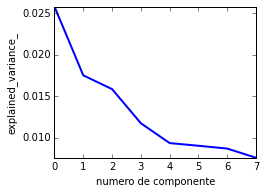

In [110]:
# Plot the PCA spectrum
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('numero de componente')
plt.ylabel('explained_variance_')

Como va decreciendo conforme aumenta el número de componentes probé con el primer tercio de los datos hasta llegar a 2500 lo cual me dio que la suma del porcentaje de variabilidad igual a 95.33% lo cual indica que el 0.04% restante está en las 5400 palabras restantes. Así pues se decide trabajar con 2500 atributos.

In [45]:
var=[]
for i in range(500,2501,500):
    pca = decomposition.PCA(n_components=i)
    pca.fit(x_train)
    var.append(sum(pca.explained_variance_ratio_))

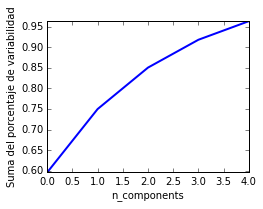

In [46]:
#plot sum of variance ratio for each n_component
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(var, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('Suma del porcentaje de variabilidad')

In [148]:
#y=np.asarray(y_pred).reshape(200,1)
x_Transf= pca.fit_transform(x_train)

#PCA con 1254 componentes

In [163]:
pca = decomposition.PCA(n_components=1254)
x_train_pca= pca.fit_transform(x_train)x

In [167]:
sum(pca.explained_variance_ratio_)

0.80666892118586708

#Bayes Naive sin PCA

In [223]:
#Train the classifier
gauss=GaussianNB()
#Ajustar y predecir
predBN_E=gauss.fit(x_train,y_train).predict(x_test)

#Verificar qué tan acertado es el modelo
accuracy_score(y_test,predBN_E)

0.58931419457735246

In [224]:
confusion_matrix(y_test,predBN_E)

array([[460, 396],
       [119, 279]])

In [225]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predBN_E,1)
roc_auc = auc(false_positive_rate, true_positive_rate)
#roc=roc_auc_score(actual,pred,pos_label=0)

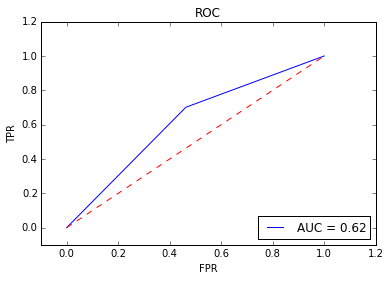

In [226]:
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [25]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_train,predBN_E,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       1.00      0.85      0.92      2650
 Negativo 1       0.73      1.00      0.85      1111

avg / total       0.92      0.89      0.90      3761



#Bayes Naive con PCA

In [233]:
#Train the classifier
gauss=GaussianNB()
#Ajustar y predecir
predBN_P=gauss.fit(x_train_pca,y_train).predict(x_test_pca)

#Verificar qué tan acertado es el modelo
accuracy_score(y_test,predBN_P)

0.61562998405103664

In [234]:
confusion_matrix(y_test,predBN_P)

array([[727, 129],
       [353,  45]])

In [235]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predBN_E,1)
roc_auc = auc(false_positive_rate, true_positive_rate)

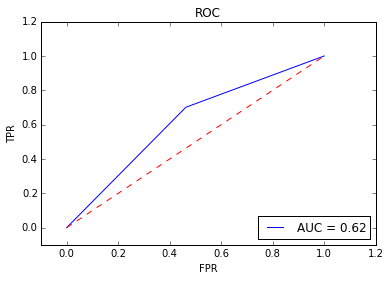

In [236]:
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [181]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test,predBN_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.67      0.85      0.75       856
 Negativo 1       0.26      0.11      0.16       398

avg / total       0.54      0.62      0.56      1254



#SVM

#Encontrar C

In [183]:
from sklearn import svm, grid_search
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(x_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [184]:
clf.best_params_ 

{'C': 1, 'kernel': 'linear'}

#SVM sin PCA

In [204]:
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
clf = SVC(C=1,kernel='linear')
clf.fit(x_train, y_train) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [205]:
#Test the classifier
predSVM_E=[0]*(len(x_test))
i=0
for z in x_test:
    predSVM_E[i]=clf.predict(z)
    i+=1

In [206]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test,predSVM_E)

0.76953748006379585

In [207]:
confusion_matrix(y_test,predSVM_E)

array([[819,  37],
       [252, 146]])

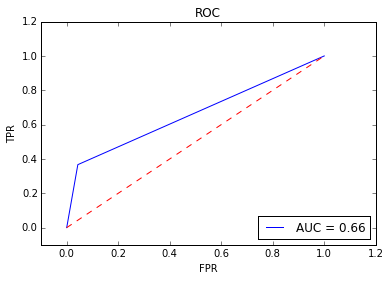

In [208]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predSVM_E, pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
#roc=roc_auc_score(actual,pred)

plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [210]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test,predSVM_E,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.76      0.96      0.85       856
 Negativo 1       0.80      0.37      0.50       398

avg / total       0.78      0.77      0.74      1254



#SVM con PCA

In [237]:
clf = SVC(C=1,kernel='linear')
clf.fit(x_train_pca, y_train) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [238]:
#Test the classifier
predSVM_P=[0]*(len(x_test_pca))
i=0
for z in x_test_pca:
    predSVM_P[i]=clf.predict(z)
    i+=1

In [239]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test, predSVM_P)

0.62200956937799046

In [240]:
confusion_matrix(y_test, predSVM_P)

array([[704, 152],
       [322,  76]])

In [242]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test, predSVM_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.69      0.82      0.75       856
 Negativo 1       0.33      0.19      0.24       398

avg / total       0.57      0.62      0.59      1254



#Árbol de Decisión sin PCA

In [211]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best')

In [212]:
#Test the classifier
predAD_P=[0]*(len(x_test))
i=0
for z in x_test:
    predAD_P[i]=clf.predict(z)
    i+=1

In [213]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test, predAD_P)

0.73923444976076558

In [214]:
confusion_matrix(y_test, predAD_P)

array([[741, 115],
       [212, 186]])

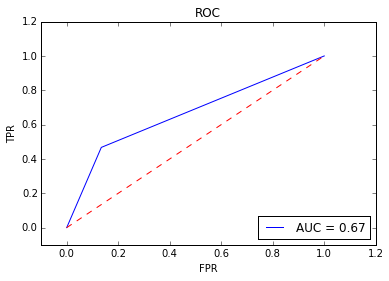

In [215]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predAD_P, pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
#roc=roc_auc_score(actual,pred)

plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [216]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test, predAD_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.78      0.87      0.82       856
 Negativo 1       0.62      0.47      0.53       398

avg / total       0.73      0.74      0.73      1254



#Árbol de Decisión con PCA

In [192]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train_pca, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=0, splitter='best')

In [194]:
#Test the classifier
predAD_P=[0]*(len(x_test_pca))
i=0
for z in x_test_pca:
    predAD_P[i]=clf.predict(z)
    i+=1

In [195]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test_pca, predAD_P)

0.55023923444976075

In [196]:
confusion_matrix(y_test, predAD_P)

array([[581, 275],
       [289, 109]])

In [198]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test, predAD_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.67      0.68      0.67       856
 Negativo 1       0.28      0.27      0.28       398

avg / total       0.55      0.55      0.55      1254



#Boosting sin PCA

In [217]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(x_train, y_train) 

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [218]:
#Test the classifier
predB_P=[0]*(len(x_test))
i=0
for z in x_test:
    predB_P[i]=clf.predict(z)
    i+=1

In [219]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test, predB_P)

0.75039872408293462

In [220]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test, predB_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.74      0.99      0.84       856
 Negativo 1       0.91      0.24      0.38       398

avg / total       0.79      0.75      0.70      1254



In [221]:
confusion_matrix(y_test, predAD_P)

array([[741, 115],
       [212, 186]])

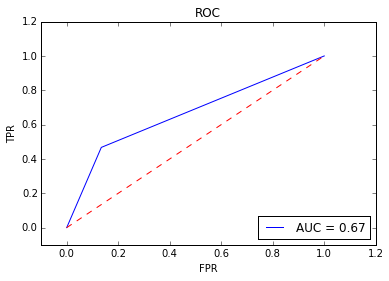

In [222]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predAD_P, pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
#roc=roc_auc_score(actual,pred)

plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

#Boosting con PCA

In [75]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(x_train_pca, y_train) 

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [199]:
#Test the classifier
predB_P=[0]*(len(x_test_pca))
i=0
for z in x_test_pca:
    predB_P[i]=clf.predict(z)
    i+=1

In [200]:
#Verificar qué tan acertado es el modelo
accuracy_score(y_test, predB_P)

0.55023923444976075

In [201]:
from sklearn import metrics
target_names = ['Positivo 0', 'Negativo 1']
print(metrics.classification_report(y_test, predB_P,[0,1],target_names))

             precision    recall  f1-score   support

 Positivo 0       0.67      0.68      0.67       856
 Negativo 1       0.28      0.27      0.28       398

avg / total       0.55      0.55      0.55      1254



In [202]:
confusion_matrix(y_test, predAD_P)

array([[581, 275],
       [289, 109]])